# Inverse PINN-THM for thermoelastic consolidation of an unsaturated stratum

Check out our paper for more details: 
**Inverse modeling of nonisothermal multiphase poromechanics using physics-informed neural networks**

Find the paper at: [https://arxiv.org/abs/2209.03276](https://arxiv.org/abs/2209.03276)

Try it out on Google Colab: [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sciann/sciann-applications/blob/master/SciANN-PoroElasticity/PINN_THM_TwoPhaseConsolidation.ipynb)


Cite our work:
```
@article{amini2022inverse,
  title={Inverse modeling of nonisothermal multiphase poromechanics using physics-informed neural networks},
  author={Amini, Danial and Haghighat, Ehsan and Juanes, Ruben},
  journal={arXiv preprint arXiv:2209.03276},
  year={2022}
}
```

In [1]:
#!pip install sciann   

In [2]:
import numpy as np 
import sciann as sn 
from sciann.utils.math import sign, abs, sigmoid, tanh, diff
import os, time
import matplotlib.pyplot as plt

---------------------- SCIANN 0.6.6.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.5.3 
Python Version: 3.7.9 (default, Aug 31 2020, 17:10:11) [MSC v.1916 64 bit (AMD64)] 



In [3]:
# Unit conversions 
s, minute, hr, day = 1., 60., 60.**2, 24*60.**2
g, kg = 1.e-3, 1.
mm, cm, m, km = 1e-3, 1e-2, 1.0, 1e3
Pa, kPa, MPa, GPa = 1.0, 1.e3, 1.e6, 1.e9
micro, milli, centi, kilo, mega = 1e-6, 1e-3, 1e-2, 1e3, 1e6
poise = 0.1*Pa*s
Darcy = 9.869233e-13*m**2

In [4]:
# ----------------------- Neural Network Setup -----------------------#ok
DTYPE = 'float32'
sn.reset_session()
sn.set_random_seed(124)

yd = sn.Variable('yd', dtype=DTYPE)
td = sn.Variable('td', dtype=DTYPE)


pcd = sn.Functional('pcd', [yd, td], 8*[40], 'tanh')
vd = sn.Functional('vd', [yd, td], 8*[40], 'tanh')
Evd = sn.Functional('Evd', [yd, td], 8*[40], 'tanh')
Td = sn.Functional('Td', [yd, td], 8*[40], 'tanh')

pwd = -pcd

In [5]:
# ----------------------- Constant Parameters-----------------------#ok

nu = 0.2857
phi = 0.5
b = 1.0
Ks, Kw, Kg = (0.14e10) *Pa, (0.43e13) *Pa, (0.1e6) *Pa
cw, cg = 1/Kw, 1/Kg

rho_s, rho_w, rho_g = 1800.0 * kg/m**3, 1000 * kg/m**3, 1.22 * kg/m**3
rho_star = (1 - phi)*rho_s + phi*0.5*rho_w + phi*0.5*rho_g
rho_s_bar, rho_w_bar, rho_g_bar = rho_s/rho_star, rho_w/rho_star, rho_g/rho_star

E = 60e6
E_star = 60e6
E_bar = sn.Parameter(2, non_neg=True, inputs=[yd, td], name='E_bar')

k = 6e-15 * m**2
k_star = 6e-15 * m**2
k_bar = sn.Parameter(2, non_neg=True, inputs=[yd, td], min_max=[0.1, 10], name='k_bar')

Lambda_avg = 0.458
Lambda_star = 0.458
Lambda_avg_bar = sn.Parameter(2, non_neg=True, inputs=[yd, td], name='Lambda_avg_bar')

mu_w, mu_g = 1e-3 * Pa * s, 1e-3 * Pa * s
mu_star = 1e-3 * Pa * s
mu_w_bar, mu_g_bar = mu_w/mu_star, mu_g/mu_star

Ly = 0.1*m
x_star = Ly

Kdr = E_bar*E_star/(3*(1-2*nu))
Kdr_star = E/(3*(1-2*nu))
Kdr_bar = Kdr/Kdr_star

Sw_ini, Sg_ini, Srw, p_bubl = 0.445, 0.555, 0.3216, 133.8 * kPa

p_star = 420 * kPa

pwd_top, pcd_top = -420*kPa/p_star, 420*kPa/p_star
pwd_ini, pcd_ini = -280*kPa/p_star, 280*kPa/p_star

beta_s, beta_w, beta_g = 0.9e-6, 6.3e-6, 3.3e-3
beta_star = 6.3e-6
beta_s_bar, beta_w_bar, beta_g_bar = beta_s/beta_star, beta_w/beta_star, beta_g/beta_star

C_s, C_w, C_g = 125460, 4182, 1000
C_star = ((1-phi)*rho_s*C_s + 0.5*phi*rho_w*C_w + 0.5*phi*rho_g*C_g)/rho_star
C_s_bar, C_w_bar, C_g_bar = C_s/C_star, C_w/C_star, C_g/C_star


In [6]:
# ----------------------- Saturation Relations -----------------------#ok

pcd_p = 0.5*(1 + sign(pcd - (pcd_ini)))*pcd + 0.5*(1 - sign(pcd - (pcd_ini)))*(pcd_ini)

S_power = 2.308
Sw = Srw + (1 - Srw)*((p_bubl/(pcd_p*p_star))**S_power)

dSw_dpcd = (1 - Srw)*((p_bubl/p_star)**S_power)*(-S_power)*(pcd_p**(-S_power-1))

Se = (Sw - Srw)/(1 - Srw)

krw = Se**((2+3*S_power)/S_power)

krg = ((1-Se)**2)*(1-Se**((2+S_power)/3))

Sg = 1 - Sw

rho_C_avg = (1-phi)*rho_s*C_s + Sw*phi*rho_w*C_w + Sg*phi*rho_g*C_g

# ----------------------- Dimensionless parameter -----------------------

M = 1/(phi*0.5*cw + phi*0.5*cg + (b - phi)/Ks) 
M_bar = M/Kdr_star

t_star = 1000*hr 
u_star = p_star*x_star/Kdr_star
T_star = 15

N_T = beta_star*Kdr_star*T_star/p_star
D_star = mu_star*(x_star**2)/(Kdr_star*k_star*t_star)
Q_star = beta_star*T_star*mu_star*(x_star**2)/(t_star*k_star*p_star)
H_star = rho_C_avg/rho_star/C_star
J_star = k_star*p_star*t_star/mu_star/(x_star**2)
F_star = t_star*Lambda_star/rho_star/C_star/(x_star**2)

N = (b - phi)/Ks
Ngg = -phi*dSw_dpcd/p_star + phi*Sg*cg + (Sg**2)*N
Nwg = phi*dSw_dpcd/p_star + Sw*Sg*N
Nww = -phi*dSw_dpcd/p_star + phi*Sw*cw + (Sw**2)*N

Ngg_bar, Nwg_bar, Nww_bar = Ngg*Kdr_star, Nwg*Kdr_star, Nww*Kdr_star

y = yd*x_star    
pw = pwd*p_star
pc = pcd*p_star
t = td*t_star   
v = vd*u_star    
T = Td*T_star

tol = 1e-5
td_0 = 0.0 
td_f = 1.0 
yd_min = 0.0 
yd_max = (Ly/x_star) 

In [7]:
# ----------------------- Solid Mechanics -----------------------

vd_yd = diff(vd, yd)
Eyyd = vd_yd
Svd = Kdr_bar*Evd - b*(pwd+Sg*pcd - (pwd_ini+Sg_ini*pcd_ini)) - beta_s_bar*Kdr_bar*N_T*Td

Svd_td = diff(Svd, td)

Syyd = Kdr_bar*Evd + 2*(1-2*nu)/(1+nu)*Kdr_bar*diff(vd, yd) - b*(pwd+Sg*pcd - (pwd_ini+Sg_ini*pcd_ini)) - \
       beta_s_bar*Kdr_bar*N_T*Td


Msy = sn.rename(Kdr_bar*diff(Evd, yd)+2*(1-2*nu)/(1+nu)*Kdr_bar*diff(vd_yd, yd) - b*diff(pwd+Sg*pcd, yd) - 
                beta_s_bar*Kdr_bar*N_T*diff(Td, yd), "Msy")
MEv = sn.rename(Evd - diff(vd, yd), "MEv")

C_v_ini = sn.rename((td == td_0)*abs(vd), "C_v_ini")
C_v_bc_1 = sn.rename((yd == yd_max)*abs(Syyd), "C_v_bc_1")
C_v_bc_2 = sn.rename((yd == yd_min)*abs(vd), "C_v_bc_2")

targets_solid = [sn.PDE(Msy), sn.PDE(MEv), C_v_ini, C_v_bc_1, C_v_bc_2, vd, vd, vd]


In [8]:
# ----------------------- Fluid Mechanics -----------------------

Svd_td_seq = sn.Variable('Svd_td_seq', dtype=DTYPE)
pwd_yd, pwd_td = diff(pwd, yd), diff(pwd, td)
pcd_yd, pcd_td = diff(pcd, yd), diff(pcd, td)
bw, bg = b*Sw, b*Sg

Mp_wet = sn.rename(-(mu_w_bar/k_bar)*(Nww_bar+(bw*bw)/Kdr_bar)*D_star*pcd_td + (mu_w_bar/k_bar)*b*Sw/Kdr_bar*D_star*Svd_td_seq-\
                   (mu_w_bar/k_bar)*phi*Sw*(beta_w_bar - beta_s_bar)*Q_star*diff(Td, td) - \
                   (diff(krw*pwd_yd, yd)), 'Mp_wet')

C_pc_ini = sn.rename((td == td_0)*abs(pcd - pcd_ini), "C_pc_ini")
C_pc_bc_1 = sn.rename((yd == yd_max)*abs(pcd - pcd_top), "C_pc_bc_1")
C_pc_bc_2 = sn.rename((yd == yd_min)*abs(pcd_yd), "C_pc_bc_2")

targets_fluid = [sn.PDE(Mp_wet), C_pc_ini, C_pc_bc_1, C_pc_bc_2,pcd,pcd,pcd]

In [9]:
# ----------------------- Energy Balance -----------------------

Td_yd, Td2_yd2, Td_td = diff(Td,yd), diff(Td, yd, order=2), diff(Td,td)

MT = sn.rename(H_star*Td_td - J_star*(rho_w_bar*C_w_bar*k_bar/mu_w_bar*krw*diff(pwd, yd))*Td_yd -
               F_star*Lambda_avg_bar*Td2_yd2, "MT")

C_T_ini = sn.rename((td == td_0)*abs(Td), "C_T_ini")
C_T_bc_1 = sn.rename((yd == yd_max)*abs(Td - 15/T_star), "C_T_bc_1")
C_T_bc_2 = sn.rename((yd == yd_min)*abs(Td_yd), "C_T_bc_2")

targets_energy = [sn.PDE(MT), C_T_ini, C_T_bc_1, C_T_bc_2, Td, Td, Td]

In [10]:
# ----------------------- prediction model -----------------------
model_pred = sn.SciModel([yd, td], [Td, pwd, pcd, vd])

# ----definition of models for sequential process-------

solid = sn.SciModel([yd, td], targets_solid)
fluid = sn.SciModel([yd, td, Svd_td_seq], targets_fluid)
thermal = sn.SciModel([yd, td], targets_energy)

#------training parameters---------

BATCH_SIZE = 500                   # higher batch size imporve the accuracy (used for the paper results = 500)
EPOCHS_FLUID = 10000                # more epochs imporve the accuracy (used for the paper results = 5000)
EPOCHS_SOLID = 10000                # more epochs imporve the accuracy (used for the paper results = 5000)
EPOCHS_THERMAL = 5000              # more epochs imporve the accuracy (used for the paper results = 5000)
STOP_AFTER = None

ADAPTIVE_WEIGHTS_THERMAL = {'method': 'GP', 'freq': 300}

ADAPTIVE_WEIGHTS_FLUID = {'method': 'GN', 'freq': 300, 'use_score': True, 'alpha': 1.5}

ADAPTIVE_WEIGHTS_SOLID = {'method': 'GN', 'freq': 300, 'use_score': True, 'alpha': 1.0}

In [11]:
#@title Collocation Points for Sensors and Model Evaluation 

#-------grid as input for model------
Ny, Nt = 41, 101
t_grid = np.linspace(td_0, td_f, Nt)
y_grid = np.linspace(yd_min, yd_max, Ny)
t_data, y_data = [v.reshape(-1, 1) for v in np.meshgrid(t_grid, y_grid)]

# -------sensor data--------
yd_1quart_sensor_ids = np.where(y_data.flatten() == yd_max/4)[0]
yd_2quart_sensor_ids = np.where(y_data.flatten() == yd_max/2)[0]
yd_3quart_sensor_ids = np.where(y_data.flatten() == 3*yd_max/4)[0]
Td_1quart_sensor = np.loadtxt('FEM_T.txt')[:,1].reshape(-1,1) / T_star
Td_2quart_sensor = np.loadtxt('FEM_T.txt')[:,2].reshape(-1,1) / T_star
Td_3quart_sensor = np.loadtxt('FEM_T.txt')[:,3].reshape(-1,1) / T_star
pcd_1quart_sensor = np.loadtxt('FEM_pc.txt')[:,1].reshape(-1,1) / p_star
pcd_2quart_sensor = np.loadtxt('FEM_pc.txt')[:,2].reshape(-1,1) / p_star
pcd_3quart_sensor = np.loadtxt('FEM_pc.txt')[:,3].reshape(-1,1) / p_star
vd_1quart_sensor = np.loadtxt('FEM_V.txt')[:,1].reshape(-1,1) / u_star
vd_2quart_sensor = np.loadtxt('FEM_V.txt')[:,2].reshape(-1,1) / u_star
vd_3quart_sensor = np.loadtxt('FEM_V.txt')[:,3].reshape(-1,1) / u_star

# -------------grid for plot--------------

log10p = lambda x: np.log10(1. + x)
Ny, Nt = 100, 301
ys = np.linspace(yd_min, yd_max, Ny)
ys_lineplot = ys
ts_lineplot = [10*hr/t_star,50*hr/t_star,100*hr/t_star,200*hr/t_star,300*hr/t_star,500*hr/t_star,1000*hr/t_star]

input_test_lineplot = np.meshgrid(ys_lineplot, ts_lineplot, indexing='ij')

# ----plot settings------

line_color = ['blue', 'green', 'red', 'purple', 'cyan', 'orange', 'black']
marker = ['>', 'v', 'd', 'o', 's', 'H', '*']
subplot_adust = [0.1, 0.15, 0.85, 0.85, 0.25, 0.25]
legend_settings = {
    'bbox_to_anchor': (1.2, 0.8),
    'loc': 'upper left',
    'fontsize': 'medium',
    'fancybox': True,
    'frameon': False
}

legend_settings_2 = {
    'bbox_to_anchor': (0.8, -1.025),
    'loc': 'lower center',
    'fontsize': 'medium',
    'fancybox': True,
    'frameon': False
}

In [17]:
#@title Post processing (plotting) functions 

def cust_semilogx(AX, X, Y, xlabel, ylabel, title, line_label=None):
    if X is None:
        im = AX.semilogy(Y, label=line_label)
    else:
        im = AX.semilogy(X, Y, label=line_label)
    if xlabel is not None: AX.set_xlabel(xlabel)
    if ylabel is not None: AX.set_ylabel(ylabel)
    if title  is not None: AX.set_title(title)  

def loss_plot(H_fluid, H_solid, H_thermal, itr):
    fig, ax = plt.subplots(3, 3, figsize=(12, 10))
    for key, val in H_fluid.history.items():
        if key.endswith("loss"):
            cust_semilogx(ax[0, 0], None, np.array(val) / val[0], None, "Fluid", "L/L0", key)
    ax[0, 0].legend(loc="upper right")
    cust_semilogx(ax[0, 1], None, np.array(H_fluid.history["lr"]), None, None, "lr")
    cust_semilogx(ax[0, 2], None, np.array(H_fluid.history["time"]), None, None, "time")

    for key, val in H_solid.history.items():
        if key.endswith("loss"):
            cust_semilogx(ax[1, 0], None, np.array(val) / val[0], None, "Solid", None, key)
    ax[1, 0].legend(loc="upper right")
    cust_semilogx(ax[1, 1], None, np.array(H_solid.history["lr"]), None, None, None)
    cust_semilogx(ax[1, 2], None, np.array(H_solid.history["time"]), None, None, None)

    for key, val in H_thermal.history.items():
        if key.endswith("loss"):
            cust_semilogx(ax[2, 0], None, np.array(val) / val[0], None, "Thermal", None, key)
    ax[2, 0].legend(loc="upper right")
    cust_semilogx(ax[2, 1], None, np.array(H_thermal.history["lr"]), None, None, None)
    cust_semilogx(ax[2, 2], None, np.array(H_thermal.history["time"]), None, None, None)
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.15, top=0.9, wspace=0.3, hspace=0.2)
    plt.savefig('Loss_itr{:02d}.jpg'.format(itr + 1), dpi=150)
    plt.show()
    plt.close()
    
def parameter_plot_itr(parameter_thermal, parameter_fluid, parameter_solid, itr):
    fig, ax = plt.subplots(1, 3, figsize=(12, 3.5))
    ax[0].plot(np.concatenate(parameter_thermal).flatten() * Lambda_star, color='red')
    ax[0].hlines(y=np.around(Lambda_avg, decimals=4), xmin=1, xmax=EPOCHS_THERMAL * (itr + 1), color='black',
                 linestyle='--')
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('${\lambda_{avg}}~(~J/s \cdot m \cdot {}^oC)$')
    ax[1].plot(np.concatenate(parameter_fluid).flatten() * k_star, color='red')
    ax[1].hlines(y=k, xmin=1, xmax=EPOCHS_FLUID * (itr + 1), color='black', linestyle='--')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('${k}~(m^2)$')
    ax[2].plot(np.concatenate(parameter_solid).flatten() * E_star / (3 * (1 - 2 * nu)), color='red')
    ax[2].hlines(y=Kdr_star, xmin=1, xmax=EPOCHS_SOLID * (itr + 1), color='black', linestyle='--')
    ax[2].set_xlabel('epochs')
    ax[2].set_ylabel('${K_{dr}}~(Pa)$')
    xticks_THERMAL = np.arange(0, EPOCHS_THERMAL*(itr+2), EPOCHS_THERMAL)
    xticks_FLUID = np.arange(0, EPOCHS_FLUID*(itr+2), EPOCHS_FLUID)
    xticks_SOLID = np.arange(0, EPOCHS_SOLID*(itr+2), EPOCHS_SOLID)
    ax[0].set_xticks(xticks_THERMAL), ax[1].set_xticks(xticks_FLUID), ax[2].set_xticks(xticks_SOLID)
    ax[0].ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
    ax[1].ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
    ax[2].ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
    ax[0].xaxis.grid(ls='--'), ax[1].xaxis.grid(ls='--'), ax[2].xaxis.grid(ls='--')
    plt.subplots_adjust(left=0.075, right=0.95, bottom=0.15, top=0.92, wspace=0.3, hspace=0.25)
    plt.savefig('Parameter_itr{:02d}.pdf'.format(itr + 1), dpi=150)
    plt.show()
    plt.close()


def Results_plot(ys_lineplot, PINN_Capillary, PINN_Temperature, PINN_Disp, itr):
    
    # -------------load data from FEM solution----------------
    Dataset_U_10hr = np.loadtxt('FEM_U_10hr.csv', delimiter=',')
    Dataset_U_50hr = np.loadtxt('FEM_U_50hr.csv', delimiter=',')
    Dataset_U_100hr = np.loadtxt('FEM_U_100hr.csv', delimiter=',')
    Dataset_U_200hr = np.loadtxt('FEM_U_200hr.csv', delimiter=',')
    Dataset_U_300hr = np.loadtxt('FEM_U_300hr.csv', delimiter=',')
    Dataset_U_500hr = np.loadtxt('FEM_U_500hr.csv', delimiter=',')
    Dataset_U_1000hr = np.loadtxt('FEM_U_1000hr.csv', delimiter=',')

    Dataset_Pc_10hr = np.loadtxt('FEM_Pc_10hr.csv', delimiter=',')
    Dataset_Pc_50hr = np.loadtxt('FEM_Pc_50hr.csv', delimiter=',')
    Dataset_Pc_100hr = np.loadtxt('FEM_Pc_100hr.csv', delimiter=',')
    Dataset_Pc_200hr = np.loadtxt('FEM_Pc_200hr.csv', delimiter=',')
    Dataset_Pc_300hr = np.loadtxt('FEM_Pc_300hr.csv', delimiter=',')
    Dataset_Pc_500hr = np.loadtxt('FEM_Pc_500hr.csv', delimiter=',')
    Dataset_Pc_1000hr = np.loadtxt('FEM_Pc_1000hr.csv', delimiter=',')

    Dataset_T_10hr = np.loadtxt('FEM_T_10hr.csv', delimiter=',')
    Dataset_T_50hr = np.loadtxt('FEM_T_50hr.csv', delimiter=',')
    Dataset_T_100hr = np.loadtxt('FEM_T_100hr.csv', delimiter=',')
    Dataset_T_200hr = np.loadtxt('FEM_T_200hr.csv', delimiter=',')
    Dataset_T_300hr = np.loadtxt('FEM_T_300hr.csv', delimiter=',')
    Dataset_T_500hr = np.loadtxt('FEM_T_500hr.csv', delimiter=',')
    Dataset_T_1000hr = np.loadtxt('FEM_T_1000hr.csv', delimiter=',')
    
    # -------plot PINN vs. FEM---------
    fig, ax = plt.subplots(2,2, figsize=(8, 7))
    marker_setting = {'ls': '', 'markevery': 3, 'markersize': 4}
    for i in range(np.size(ts_lineplot)):
        time_plot = int(ts_lineplot[i]*t_star/hr)
        ax[0, 0].plot(ys_lineplot * x_star, PINN_Capillary[:, i], color=line_color[i])
        ax[0, 1].plot(ys_lineplot * x_star, PINN_Temperature[:, i], color=line_color[i])
        ax[1, 0].plot(ys_lineplot * x_star, PINN_Disp[:, i], color=line_color[i], label='PINN-'+str(time_plot)+' hr')

    ax[0,0].plot(Dataset_Pc_10hr[:, 0], Dataset_Pc_10hr[:, 1], label='10', color='blue', marker=marker[0], **marker_setting)
    ax[0,0].plot(Dataset_Pc_50hr[:, 0], Dataset_Pc_50hr[:, 1], label='50', color='green', marker=marker[1], **marker_setting)
    ax[0,0].plot(Dataset_Pc_100hr[:, 0], Dataset_Pc_100hr[:, 1], label='100', color='red', marker=marker[2], **marker_setting)
    ax[0,0].plot(Dataset_Pc_200hr[:, 0], Dataset_Pc_200hr[:, 1], label='200', color='purple', marker=marker[3], **marker_setting)
    ax[0,0].plot(Dataset_Pc_300hr[:, 0], Dataset_Pc_300hr[:, 1], label='300', color='cyan', marker=marker[4], **marker_setting)
    ax[0,0].plot(Dataset_Pc_500hr[:, 0], Dataset_Pc_500hr[:, 1], label='500', color='orange', marker=marker[5], **marker_setting)
    ax[0,0].plot(Dataset_Pc_1000hr[:, 0], Dataset_Pc_1000hr[:, 1], label='1000', color='black', marker=marker[6], **marker_setting)

    ax[0,0].set_xlabel('Height (m)')
    ax[0,0].set_ylabel('Capillary Pressure (kPa)')
    ax[0,0].set_ylim(275, 425)
    ax[0,0].set_xlim(-0.001, 0.101),ax[0,0].grid(True, ls='--')

    ax[0,1].plot(Dataset_T_10hr[:, 0], Dataset_T_10hr[:, 1], label='FEM-10 hr', color='blue', marker=marker[0],**marker_setting)
    ax[0,1].plot(Dataset_T_50hr[:, 0], Dataset_T_50hr[:, 1], label='FEM-50 hr', color='green', marker=marker[1],**marker_setting)
    ax[0,1].plot(Dataset_T_100hr[:, 0], Dataset_T_100hr[:, 1], label='FEM-100 hr', color='red', marker=marker[2],**marker_setting)
    ax[0,1].plot(Dataset_T_200hr[:, 0], Dataset_T_200hr[:, 1], label='FEM-200 hr', color='purple', marker=marker[3],**marker_setting)
    ax[0,1].plot(Dataset_T_300hr[:, 0], Dataset_T_300hr[:, 1], label='FEM-300 hr', color='cyan', marker=marker[4],**marker_setting)
    ax[0,1].plot(Dataset_T_500hr[:, 0], Dataset_T_500hr[:, 1], label='FEM-500 hr', color='orange', marker=marker[5],**marker_setting)
    ax[0,1].plot(Dataset_T_1000hr[:, 0], Dataset_T_1000hr[:, 1], label='FEM-1000 hr', color='black', marker=marker[6],**marker_setting)

    ax[0,1].set_xlabel('Height (m)')
    ax[0,1].set_ylabel('Temperature  ${(T~-~T_0)}$ $({}^o K)$')
    ax[0,1].set_ylim(-0.5, 16.5)
    ax[0,1].set_xlim(-0.001, 0.101), ax[0,1].grid(True, ls='--')

    ax[1,0].plot(Dataset_U_10hr[:,0], Dataset_U_10hr[:,1], color='blue', marker=marker[0], **marker_setting)
    ax[1,0].plot(Dataset_U_50hr[:,0], Dataset_U_50hr[:,1], color='green', marker=marker[1], **marker_setting)
    ax[1,0].plot(Dataset_U_100hr[:,0], Dataset_U_100hr[:,1], color='red', marker=marker[2], **marker_setting)
    ax[1,0].plot(Dataset_U_200hr[:,0], Dataset_U_200hr[:,1], color='purple', marker=marker[3], **marker_setting)
    ax[1,0].plot(Dataset_U_300hr[:,0], Dataset_U_300hr[:,1], color='cyan', marker=marker[4], **marker_setting)
    ax[1,0].plot(Dataset_U_500hr[:,0], Dataset_U_500hr[:,1], color='orange', marker=marker[5], **marker_setting)
    ax[1,0].plot(Dataset_U_1000hr[:,0], Dataset_U_1000hr[:,1], color='black', marker=marker[6], **marker_setting)

    ax[1,0].set_xlabel('Height (m)')
    ax[1,0].set_ylabel('Vertical Displacement (m)')

    ax[1,0].set_ylim(-4e-5,0.25e-5)
    ax[1,0].set_xlim(-0.001, 0.101), ax[1,0].grid(True, ls='--')
    ax[1,1].axis('off')
    ax[1,0].legend(**legend_settings)
    ax[0,1].legend(**legend_settings_2)
    plt.subplots_adjust(left=0.1, right=0.97, bottom=0.07, top=0.97, wspace=0.25, hspace=0.25)
    plt.savefig('Results_itr{:02d}.pdf'.format(itr+1), dpi=150)
    plt.show()
    plt.close()


In [13]:
# ---------------------Sequential Training Algorithm---------------------------

n_itr = 4
parameter_thermal, parameter_fluid, parameter_solid = [], [], []
Svd_td_data = np.zeros_like(y_data)
start_time = time.time()

initial_lr = 5e-4
final_lr = initial_lr/100

for itr in range(n_itr):

    itr_time = time.time()
    if itr == 0:
        kwrds_thermal = {'adaptive_weights': ADAPTIVE_WEIGHTS_THERMAL}
        kwrds_fluid = {'adaptive_weights': ADAPTIVE_WEIGHTS_FLUID}
        kwrds_solid = {'adaptive_weights': ADAPTIVE_WEIGHTS_SOLID}
    else:
        kwrds_thermal = {}
        kwrds_fluid = {}
        kwrds_solid = {}

    if itr >= 3:
        initial_lr = initial_lr / 1.75

    vd.set_trainable(False)
    Evd.set_trainable(False)
    Td.set_trainable(True)
    pcd.set_trainable(False)
    Lambda_avg_bar.set_trainable(True)
    k_bar.set_trainable(False)
    E_bar.set_trainable(False)
    thermal.compile()

    H_thermal = thermal.train(
        [y_data, t_data],
        4*['zeros'] + [(yd_1quart_sensor_ids, Td_1quart_sensor)] + 
          [(yd_2quart_sensor_ids, Td_2quart_sensor)] + [(yd_3quart_sensor_ids, Td_3quart_sensor)],
        learning_rate={"scheduler": "ExponentialDecay",
                       "initial_learning_rate": initial_lr,
                       "final_learning_rate": final_lr,
                       "decay_epochs": EPOCHS_THERMAL
                       },
        epochs=EPOCHS_THERMAL,
        batch_size=BATCH_SIZE,
        stop_loss_value=1e-8,
        stop_after=STOP_AFTER,
        verbose=0,
        log_parameters={'parameters': Lambda_avg_bar, 'freq': 1},
        **kwrds_thermal
    )
    thermal.save_weights('thermal_weights_itr{:02d}.hdf5'.format(itr + 1))

    vd.set_trainable(False)
    Evd.set_trainable(False)
    Td.set_trainable(False)
    pcd.set_trainable(True)
    Lambda_avg_bar.set_trainable(False)
    k_bar.set_trainable(True)
    E_bar.set_trainable(False)
    fluid.compile()

    H_fluid = fluid.train(
        [y_data, t_data, Svd_td_data],
        4*['zeros'] + [(yd_1quart_sensor_ids, pcd_1quart_sensor)] + 
          [(yd_2quart_sensor_ids, pcd_2quart_sensor)] + [(yd_3quart_sensor_ids, pcd_3quart_sensor)],
        learning_rate={"scheduler": "ExponentialDecay",
                       "initial_learning_rate": initial_lr,
                       "final_learning_rate": final_lr,
                       "decay_epochs": EPOCHS_FLUID
                       },
        epochs=EPOCHS_FLUID,
        batch_size=BATCH_SIZE,
        stop_loss_value=1e-8,
        stop_after=STOP_AFTER,
        verbose=0,
        log_parameters={'parameters': k_bar, 'freq': 1},
        **kwrds_fluid
    )

    fluid.save_weights('fluid_weights_itr{:02d}.hdf5'.format(itr + 1))

    vd.set_trainable(True)
    Evd.set_trainable(True)
    Td.set_trainable(False)
    pcd.set_trainable(False)
    Lambda_avg_bar.set_trainable(False)
    k_bar.set_trainable(False)
    E_bar.set_trainable(True)
    solid.compile()

    H_solid = solid.train(
        [y_data, t_data],
        5*['zeros'] + [(yd_1quart_sensor_ids, vd_1quart_sensor)] + 
          [(yd_2quart_sensor_ids, vd_2quart_sensor)] + [(yd_3quart_sensor_ids, vd_3quart_sensor)],
        learning_rate={"scheduler": "ExponentialDecay",
                       "initial_learning_rate": initial_lr,
                       "final_learning_rate": final_lr,
                       "decay_epochs": EPOCHS_SOLID
                       },
        epochs=EPOCHS_SOLID,
        batch_size=BATCH_SIZE,
        stop_loss_value=1e-8,
        stop_after=STOP_AFTER,
        verbose=0,
        log_parameters={'parameters': E_bar, 'freq': 1},
        **kwrds_solid
    )
    solid.save_weights('solid_weights_itr{:02d}.hdf5'.format(itr + 1))

    Svd_td_data = (Svd_td.eval(model_pred, [y_data, t_data]))

    parameter_thermal += H_thermal.history['Lambda_avg_bar']
    parameter_fluid += H_fluid.history['k_bar']
    parameter_solid += H_solid.history['E_bar']
    print('\n -- iteration {} is completed in {}s, total in {}s... \n'.format(
        itr + 1, time.time() - itr_time, time.time() - start_time)
    )

    


Total samples: 4141 
Batch size: 500 
Total batches: 9 


+ adaptive_weights at epoch 1: [0.9000020989839186, 1.5395269474144708, 0.9337411090959924, 0.9236393697771905, 0.9011095735803581, 0.9014086713582611, 0.9005722297898088]

+ adaptive_weights at epoch 301: [0.810713217527198, 1.49324723081559, 1.1396171139092564, 0.9980420637137529, 0.8987749031002719, 0.8286475369767405, 0.8309579339571906]

+ adaptive_weights at epoch 601: [0.7309823981488698, 1.4824464514950662, 1.2111066793505263, 1.0418360960681035, 0.9353574383772575, 0.8376331739995011, 0.7606378162048565]

+ adaptive_weights at epoch 901: [0.6590362518885401, 1.4632352198511873, 1.3425363361290557, 1.104761115384087, 0.9269909292528544, 0.7920555017111102, 0.7113847530715257]

+ adaptive_weights at epoch 1201: [0.5935036971905121, 1.4923510102177906, 1.426281163502722, 1.1832291246588962, 0.8749028371051646, 0.7653517511490027, 0.6643805771084531]

+ adaptive_weights at epoch 1501: [0.5348180712817581, 1.475839678243248


+ adaptive_weights at epoch 7501: [6.583071056751397, 0.06762917824080424, 0.06463079542598686, 0.09083588627122582, 0.0646109510550691, 0.0646109677146449, 0.06461091643653841]

+ adaptive_weights at epoch 7801: [6.62072188533298, 0.06196373500763072, 0.058170876673490586, 0.0846938625552605, 0.058149861657510314, 0.058149878153472605, 0.058149833564430264]

+ adaptive_weights at epoch 8101: [6.621198222877128, 0.05689889851511602, 0.05235678816695038, 0.11254134066849963, 0.05233488004842412, 0.052334898137156804, 0.0523348508873194]

+ adaptive_weights at epoch 8401: [6.6466528555061375, 0.052557275878058675, 0.04712419713058399, 0.11236133595742365, 0.04710139705028185, 0.04710141720064361, 0.04710137040261355]

+ adaptive_weights at epoch 8701: [6.674654066121489, 0.04884468748031631, 0.042415735783203456, 0.1069114402788306, 0.04239126306688335, 0.042391290778807926, 0.04239123485852251]

+ adaptive_weights at epoch 9001: [6.70196218244803, 0.045618596059077206, 0.03817813032203


+ adaptive_weights at epoch 9301: [0.15768767463696023, 0.2565743245830213, 5.948561737827877, 0.38607215726630045, 0.9101265913048808, 0.11826448675162726, 0.10098767569446651, 0.12172539887352514]

+ adaptive_weights at epoch 9601: [0.15327067941515665, 0.2400430122068359, 6.0492480221207465, 0.3693416187238677, 0.8626508702641772, 0.11133618741802515, 0.09601509501258473, 0.11809448131099441]

+ adaptive_weights at epoch 9901: [0.14407837428166695, 0.23617767116159524, 6.142732527027279, 0.3524280843374779, 0.8092227395325631, 0.10305917332869304, 0.09561046177022514, 0.11669110937647303]

 -- iteration 1 is completed in 4122.780622243881s, total in 4122.780622243881s... 


Total samples: 4141 
Batch size: 500 
Total batches: 9 


+ adaptive_weights at epoch 1: [0.17354375594675422, 1.2620524750769213, 1.8978051355333054, 1.7770670876517414, 0.7679614231498908, 0.7061831052856263, 0.41538729898770727]

+ adaptive_weights at epoch 301: [0.15678686548499557, 1.2167830577276684, 1.916


+ adaptive_weights at epoch 6001: [6.933407826758941, 0.017250275904615267, 0.0037010201288122497, 0.03650753876903311, 0.0030444206239937524, 0.0030444096925407896, 0.003044225023284451]

+ adaptive_weights at epoch 6301: [6.9316012057880405, 0.01824472150244963, 0.003552504913073388, 0.03838082810247277, 0.002740167136695822, 0.002740265750097751, 0.0027400130214645245]

+ adaptive_weights at epoch 6601: [6.934841300236912, 0.017158399085839552, 0.003345612042198202, 0.03725554121991956, 0.0024663117059905196, 0.002466340204486281, 0.0024660877250645375]

+ adaptive_weights at epoch 6901: [6.937227294486319, 0.016344748647935947, 0.0031511675993386576, 0.0366172433822518, 0.0022197206768858726, 0.002219797267119861, 0.0022195298455534272]

+ adaptive_weights at epoch 7201: [6.938375082421675, 0.01557392883480028, 0.0029951584373956314, 0.03706196259346573, 0.00199781098717063, 0.0019979314864220186, 0.0019976346881870185]

+ adaptive_weights at epoch 7501: [6.923084239962153, 0.0165


+ adaptive_weights at epoch 7801: [0.2210489257777223, 0.22225017527380614, 4.757736503160184, 0.920243300027593, 1.3397067275057084, 0.1683644765121468, 0.19085719535727474, 0.17979289755124114]

+ adaptive_weights at epoch 8101: [0.22180673459800704, 0.29627336223891587, 4.739233244590054, 0.8600643286963866, 1.3370544272829246, 0.17243457342047508, 0.1899740365588025, 0.18315970835683262]

+ adaptive_weights at epoch 8401: [0.2103808120083221, 0.29625685399834434, 4.627712276684853, 1.0136662049645047, 1.3090167105712247, 0.17199095751795787, 0.1915664863860058, 0.17940980515714905]

+ adaptive_weights at epoch 8701: [0.20860876655383456, 0.2835557460862305, 4.632449004250821, 0.9793817212651046, 1.324332608533711, 0.17636582448402932, 0.20355486024848163, 0.19175146857778713]

+ adaptive_weights at epoch 9001: [0.22103201444862555, 0.2929357051884163, 4.694536336564297, 0.9208264595039514, 1.2988747385530333, 0.17494896975685878, 0.20584755127490634, 0.19099834540931776]

+ adapti


+ adaptive_weights at epoch 4201: [6.922002042030333, 0.01906289254177686, 0.0030617919187059224, 0.055191172755716666, 0.00022640101686486247, 0.00021515166939502329, 0.00024088016083047373]

+ adaptive_weights at epoch 4501: [6.917415027119737, 0.018903448288383088, 0.003641233989561546, 0.05939921536510055, 0.0002097157169588176, 0.0001952615591521131, 0.0002362158840074225]

+ adaptive_weights at epoch 4801: [6.917541926476545, 0.01902085780602876, 0.003666997490041507, 0.05916211026874326, 0.000198497090930264, 0.0001865228459403022, 0.00022329686212701328]

+ adaptive_weights at epoch 5101: [6.9193263205306845, 0.018352269599340595, 0.0034170612532572345, 0.058312198689929526, 0.0001865747233966274, 0.00017857982161348777, 0.00022723148951383528]

+ adaptive_weights at epoch 5401: [6.907126988256489, 0.01749681417615068, 0.003438653537021135, 0.07115552842033485, 0.00024133010842567008, 0.000259953372513589, 0.00028093258751788884]

+ adaptive_weights at epoch 5701: [6.901179499


+ adaptive_weights at epoch 6001: [0.3729019950506614, 0.18839980779686163, 5.025190728400715, 0.5950078480141922, 1.2264750701125868, 0.164130747886939, 0.1643848622282731, 0.2635090075649964]

+ adaptive_weights at epoch 6301: [0.4752229835393822, 0.1884617714870101, 4.933596603230063, 0.5792704397305092, 1.1800933387704444, 0.1859824202697811, 0.2109435068991056, 0.2464291238283357]

+ adaptive_weights at epoch 6601: [0.43779166730212543, 0.215044302883684, 4.790170779152051, 0.5690896971616823, 1.1591636574948576, 0.17543706704541528, 0.19641278331415662, 0.45689015293438895]

+ adaptive_weights at epoch 6901: [0.40595674070869997, 0.21182444506336756, 4.874707329609592, 0.5595171324654094, 1.1349622983744443, 0.2082948648859957, 0.1856130893136665, 0.41912418004509544]

+ adaptive_weights at epoch 7201: [0.39042612564000667, 0.19914830712196874, 4.864189610470679, 0.5255434984200013, 1.2762629836449673, 0.19122003473494023, 0.17304388993684816, 0.38016557685267893]

+ adaptive_we


+ adaptive_weights at epoch 2401: [6.860449377323349, 0.03734942964237778, 0.01632845021116715, 0.08439300907876976, 0.0004975799056318881, 0.0004898718257477431, 0.0004928254222176974]

+ adaptive_weights at epoch 2701: [6.869535911318368, 0.03428077064164956, 0.014801973882534548, 0.08003704958817763, 0.0004503160505644153, 0.0004446023681750278, 0.00044980823763965454]

+ adaptive_weights at epoch 3001: [6.879770177058544, 0.031487018468359496, 0.013357070096577637, 0.07416567501467447, 0.00040794562781235294, 0.0004021795468579636, 0.0004103325371219973]

+ adaptive_weights at epoch 3301: [6.881175249330651, 0.03412948202935444, 0.012070535460585325, 0.07142465013398819, 0.00040574591933583104, 0.00039307182510391037, 0.0004017124755153712]

+ adaptive_weights at epoch 3601: [6.884431667992361, 0.03285045664574703, 0.010907268029699772, 0.07070061427357222, 0.00037604123110103075, 0.00036205459065559106, 0.00037211058249225445]

+ adaptive_weights at epoch 3901: [6.850594208953343


+ adaptive_weights at epoch 4501: [0.4924714668729014, 0.1974214655017328, 4.713580541173781, 0.8941086099092426, 1.1537574288098176, 0.1335323114512243, 0.20615482230718868, 0.20897374289441872]

+ adaptive_weights at epoch 4801: [0.45327108613193784, 0.5195997848807287, 4.53931927450305, 0.8279995088924871, 1.1195085724315592, 0.1484440115682518, 0.1952634276770792, 0.19659473624625812]

+ adaptive_weights at epoch 5101: [0.5837750357051368, 0.482056880680793, 4.3903259078786, 0.7826983516356759, 1.1707744898035268, 0.14647039074214757, 0.19188866781178351, 0.25201050373010403]

+ adaptive_weights at epoch 5401: [0.5536621688642592, 0.4757133448814269, 4.594437021888993, 0.7198693344296827, 1.106905670349607, 0.1364308973943986, 0.1783523960535135, 0.23462944777006572]

+ adaptive_weights at epoch 5701: [0.6397325458466839, 0.4643297514379539, 4.434955646649415, 0.6977564218836929, 1.2165168854980468, 0.1350110003690471, 0.1830744200641642, 0.22862370376025884]

+ adaptive_weights a

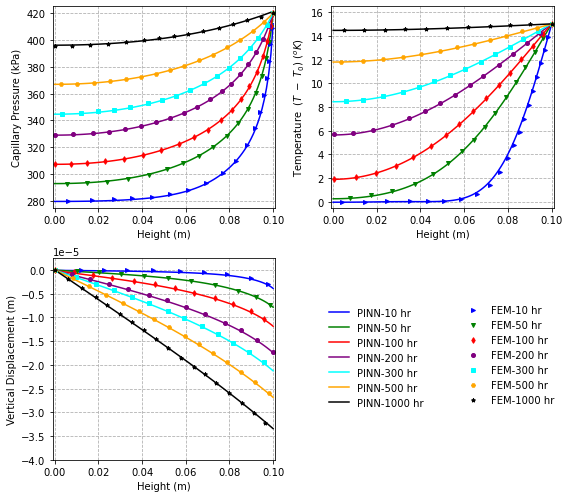

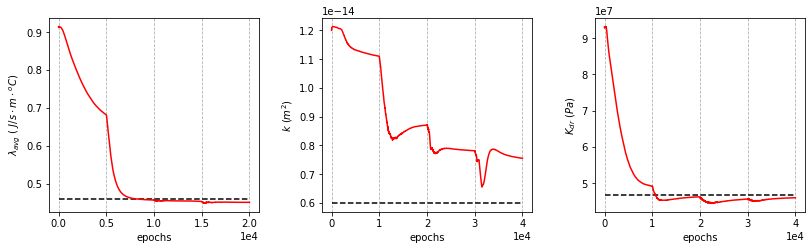

In [18]:
# -------Plots----------

PINN_Disp = vd.eval(model_pred, input_test_lineplot)*u_star/m
PINN_Capillary = pcd.eval(model_pred, input_test_lineplot)*p_star/kPa
PINN_Temperature = Td.eval(model_pred, input_test_lineplot)*T_star

Results_plot(ys_lineplot, PINN_Capillary, PINN_Temperature, PINN_Disp, itr)

parameter_plot_itr(parameter_thermal, parameter_fluid, parameter_solid, itr)

In [ ]:
# as reported in the paper, we found that the permeability is a little sensitive to optimization hyper parameters.
# the learning rate reduction during the training and the number of epochs and iterations play significant role.